# **Convolutional Neural Networks**

## **Importing Libraries**

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.optimizers import Adam

## **Loading Data**

In [2]:
df = pd.read_csv('datasets/combined_dataset.csv')

df.head(10)

,content,dataset,label
0,PrestaShop Recipes A Problem Solution Approach...,D3DreamMarket,NO
1,Nice post bond. Just remove typo - Or...,D4Garage4hackers,NO
2,Latest version of wifite (v2) has also inclu...,D4Garage4hackers,YES
3,"On Sunday, the 28th of November 2010 around ...",D4Garage4hackers,YES
4,I have to strongly disagree with the statement...,D2Twitter,NO
5,[RT] [USERNAME] Hack Remote Windows 10 Passwor...,D2Twitter,YES
6,how to crack realityking.com,D2CrackingFire,NO
7,THE BEST PRO WIFI HACKING TOOLS PACK 2017 Her...,D3DreamMarket,YES
8,[RT] [USERNAME] Analysing the NULL SecurityDes...,D2Twitter,YES
9,Quote: Originally Posted by ShockiNN Well the ...,D1CrackingArena,NO


## **Text Preprocessing**

In [3]:
df = df.drop(columns=['dataset'])

df.head(10)

,content,label
0,PrestaShop Recipes A Problem Solution Approach...,NO
1,Nice post bond. Just remove typo - Or...,NO
2,Latest version of wifite (v2) has also inclu...,YES
3,"On Sunday, the 28th of November 2010 around ...",YES
4,I have to strongly disagree with the statement...,NO
5,[RT] [USERNAME] Hack Remote Windows 10 Passwor...,YES
6,how to crack realityking.com,NO
7,THE BEST PRO WIFI HACKING TOOLS PACK 2017 Her...,YES
8,[RT] [USERNAME] Analysing the NULL SecurityDes...,YES
9,Quote: Originally Posted by ShockiNN Well the ...,NO


### **Step 1: Text Normalisation**

In [4]:
def normalisation(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)     # Remove links
    text = re.sub(r'[^a-zA-Z\s]', '', text)                 # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()                # Remove extra spaces
    return text.lower()                                     # Convert to lowercase

df['content'] = df['content'].apply(normalisation)
df.head(10)

,content,label
0,prestashop recipes a problem solution approach...,NO
1,nice post bond just remove typo originally pos...,NO
2,latest version of wifite v has also included t...,YES
3,on sunday the th of november around utc the ma...,YES
4,i have to strongly disagree with the statement...,NO
5,rt username hack remote windows password in pl...,YES
6,how to crack realitykingcom,NO
7,the best pro wifi hacking tools pack here we f...,YES
8,rt username analysing the null securitydescrip...,YES
9,quote originally posted by shockinn well the s...,NO


### **Step 2: Stopwords Removal**

In [5]:
stop_words = set(stopwords.words('english'))

df['content'] = df['content'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

### **Step 3: Tokenisation and Lemmatization**

In [6]:
lemmatizer = WordNetLemmatizer()

df['content'] = df['content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x)]))

df.head(10)

,content,label
0,prestashop recipe problem solution approach cu...,NO
1,nice post bond remove typo originally posted b...,NO
2,latest version wifite v also included attack v...,YES
3,sunday th november around utc main brdistribut...,YES
4,strongly disagree statement story phone hacked...,NO
5,rt username hack remote window password plain ...,YES
6,crack realitykingcom,NO
7,best pro wifi hacking tool pack figured three ...,YES
8,rt username analysing null securitydescriptor ...,YES
9,quote originally posted shockinn well site gav...,NO


## **Model Training**

In [7]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['content'])

X_seq = tokenizer.texts_to_sequences(df['content'])
X = pad_sequences(X_seq, padding='post', maxlen=100)
y = df['label']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 1692
Testing set size: 424


In [8]:
# Build CNN model
cnn = Sequential()

# Embedding layer
cnn.add(Embedding(input_dim=10000, output_dim=128))

# Convolutional layer
cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Max pooling layer
cnn.add(MaxPooling1D(pool_size=4))

# Global Max Pooling
cnn.add(GlobalMaxPooling1D())

# Dense layer
cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
history = cnn.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.5952 - loss: 0.6747 - val_accuracy: 0.7524 - val_loss: 0.6057
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8144 - loss: 0.5361 - val_accuracy: 0.8443 - val_loss: 0.4343
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.9265 - loss: 0.3058 - val_accuracy: 0.8892 - val_loss: 0.3237
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 0.9652 - loss: 0.1486 - val_accuracy: 0.9057 - val_loss: 0.2610
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.9883 - loss: 0.0701 - val_accuracy: 0.9057 - val_loss: 0.2563
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.9885 - loss: 0.0399 - val_accuracy: 0.9127 - val_loss: 0.2563
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.9938 - loss: 0.0277 - val_accuracy: 0.9198 - val_loss: 0.2613
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.9959 - loss: 0.0203 - val_accuracy: 0.9198

In [9]:
# Evaluate the model
cnn_loss, cnn_acc = cnn.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {cnn_acc:.2f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9296 - loss: 0.2624
CNN Model Accuracy: 0.92


## **Model Evaluation**

In [10]:
# Evaluate the model
cnn_loss, cnn_acc = cnn.evaluate(X_test, y_test)
print(f"CNN Model Accuracy: {cnn_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9296 - loss: 0.2624
CNN Model Accuracy: 0.9245


In [11]:
# Predict on test data
y_pred_prob = cnn.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Generate classification report
print(classification_report(y_test, y_pred, target_names=['0 (No)', '1 (Yes)']))

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
              precision    recall  f1-score   support

      0 (No)       0.93      0.92      0.93       217
     1 (Yes)       0.91      0.93      0.92       207

    accuracy                           0.92       424
   macro avg       0.92      0.92      0.92       424
weighted avg       0.92      0.92      0.92       424



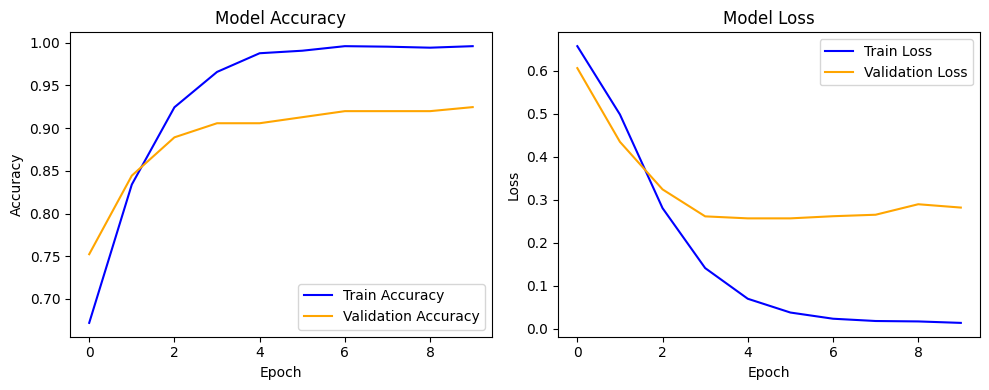

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot training and validation accuracy
ax[0].plot(history.history['accuracy'], label='Train Accuracy', color='blue')
ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot training and validation loss
ax[1].plot(history.history['loss'], label='Train Loss', color='blue')
ax[1].plot(history.history['val_loss'], label='Validation Loss', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()